All imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path
import turicreate as tc
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Flatten, Dropout
from keras.optimizers import SGD, Adamax
from keras.layers import Concatenate
from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


# Part 1

### Exercise 1

In [2]:
data_dir = 'ml-100k'

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(path.join(data_dir, 'u1.base'), delimiter='\t', names=r_cols)
r_data = data.groupby('movie_id')['rating'].mean().reset_index(name='rating')
round_r_data = r_data.astype(int)
round_r_data.shape

(1650, 2)

### 3 highest rating movies

In [3]:
i_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
          'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
          'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
data_i = pd.read_csv(path.join(data_dir, 'u.item'), delimiter='|', names=i_cols, encoding='latin-1')
movies_rating = data_i.merge(r_data, on='movie_id', how='inner')
movies_avg_rating = movies_rating.filter(['movie_id', 'movie_title', 'user_id', 'rating'])
movies_avg_rating = movies_avg_rating.sort_values(by='rating', ascending=False)
print("highest rating movies: ")
print(movies_avg_rating.head(3)['movie_title'])


highest rating movies: 
1181                                   Prefontaine (1997)
1620    Entertaining Angels: The Dorothy Day Story (1996)
1566                        Someone Else's America (1995)
Name: movie_title, dtype: object


### Histogram Of Number Of Movies With Each Average Rating 

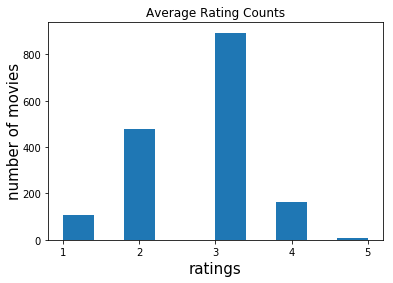

In [4]:
plt.hist([round_r_data['rating']])
plt.xlabel("ratings", fontsize=15)
plt.xticks(range(1, 6))
plt.ylabel("number of movies", fontsize=15, labelpad=0)
plt.title("Average Rating Counts")
plt.show()


### Create female_rating and male_rating

In [5]:
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
data_u = pd.read_csv(path.join(data_dir, 'u.user'), delimiter='|', names=u_cols)
users_ratings = data.merge(data_u, on='user_id', how='inner')

males = users_ratings.loc[users_ratings['gender'] == 'M']
females = users_ratings.loc[users_ratings['gender'] == 'F']

female_rating = females.groupby(['movie_id'])['rating'].mean().reset_index(name='rating')
round_female_data = female_rating.astype(int)

male_rating = males.groupby(['movie_id'])['rating'].mean().reset_index(name='rating')
round_male_data = male_rating.astype(int)

round_male_data.shape


(1555, 2)

### Average Rating Movie Counts For Males

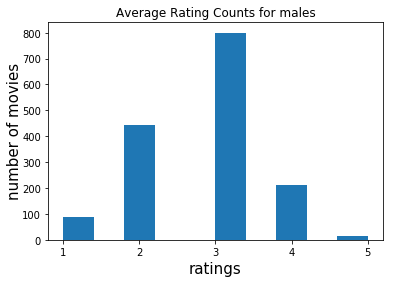

In [6]:
plt.hist([round_male_data['rating']])
plt.xlabel("ratings", fontsize=15)
plt.xticks(range(1, 6))
plt.ylabel("number of movies", fontsize=15, labelpad=0)
plt.title("Average Rating Counts for males")
plt.show()


### Average Rating Movie Counts For Females

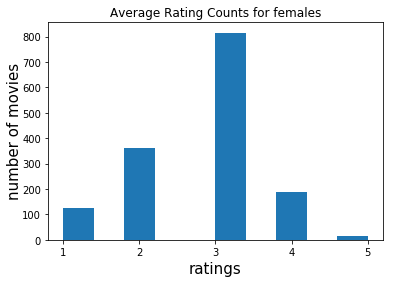

In [7]:
plt.hist([round_female_data['rating']])
plt.xlabel("ratings", fontsize=15)
plt.xticks(range(1, 6))
plt.ylabel("number of movies", fontsize=15, labelpad=0)
plt.title("Average Rating Counts for females")
plt.show()


### Comparison Between Female And Male

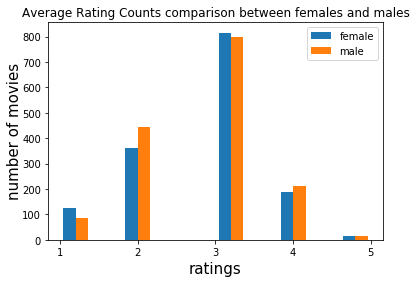

In [8]:

plt.hist([round_female_data['rating'], round_male_data['rating']])
plt.legend(['female', 'male'])
plt.xlabel("ratings", fontsize=15)
plt.xticks(range(1, 6))
plt.ylabel("number of movies", fontsize=15, labelpad=0)
plt.title("Average Rating Counts comparison between females and males")
plt.show()


### Females Highest Rating Movies 

In [9]:

female_movies_ratings = females.merge(data_i, on='movie_id', how='inner').filter(['movie_id', 'movie_title', 
                                                                                  'user_id', 'age', 'rating'])
female_movies_ratings = female_movies_ratings.sort_values(by='rating', ascending=False).drop_duplicates('movie_title')

print('Females highest ratings: ')
print(female_movies_ratings.head(3)['movie_title'])


Females highest ratings: 
3865                                   Men in Black (1997)
4541                          To Kill a Mockingbird (1962)
18288    Wallace & Gromit: The Best of Aardman Animatio...
Name: movie_title, dtype: object


### Males Highest Rating Movies

In [10]:
male_movies_ratings = males.merge(data_i, on='movie_id', how='inner').filter(['movie_id', 'movie_title',
                                                                              'user_id', 'age', 'rating'])

male_movies_ratings = male_movies_ratings.sort_values(by='rating', ascending=False).drop_duplicates('movie_title')

print('Males highest ratings: ')
print(male_movies_ratings.head(3)['movie_title'])


Males highest ratings: 
0                Toy Story (1995)
13513    L.A. Confidential (1997)
36867    Full Metal Jacket (1987)
Name: movie_title, dtype: object


### Histogram Of Rating Difference Between Female And Male

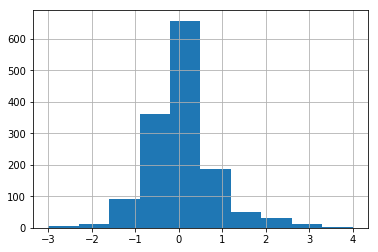

In [11]:
avg_ratings = male_rating.merge(female_rating, on="movie_id", how="inner", suffixes=("_male", "_female"))


avg_ratings["difference"] = avg_ratings["rating_male"] - avg_ratings["rating_female"]

difference_ratings = avg_ratings["difference"].dropna()
difference_ratings.hist()


### 3 Movies Females Rated Higher Than Males 

In [12]:
avg_ratings_sorted_by_difference = avg_ratings.merge(data_i, on="movie_id", how="inner").sort_values(by="difference")
print("3 movies females rated higher than males: ")
print(avg_ratings_sorted_by_difference.head(3)['movie_title'])

3 movies females rated higher than males: 
1338    Visitors, The (Visiteurs, Les) (1993)
819              In the Line of Duty 2 (1987)
1409                       Rough Magic (1995)
Name: movie_title, dtype: object


### 3 Movies Males Rated Higher Than Females

In [13]:
print("3 movies males rated higher than females: ")
print(avg_ratings_sorted_by_difference.tail(3)['movie_title'])

3 movies males rated higher than females: 
1315                           Sliding Doors (1998)
830     Two or Three Things I Know About Her (1966)
1131                               Hugo Pool (1997)
Name: movie_title, dtype: object


### Genre Distribution 

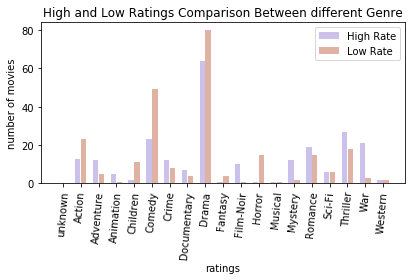

{'unknown': 0, 'Action': 13, 'Adventure': 12, 'Animation': 5, 'Children': 2, 'Comedy': 23, 'Crime': 12, 'Documentary': 7, 'Drama': 64, 'Fantasy': 1, 'Film-Noir': 10, 'Horror': 1, 'Musical': 1, 'Mystery': 12, 'Romance': 19, 'Sci-Fi': 6, 'Thriller': 27, 'War': 21, 'Western': 2}
{'unknown': 0, 'Action': 23, 'Adventure': 5, 'Animation': 1, 'Children': 11, 'Comedy': 49, 'Crime': 8, 'Documentary': 4, 'Drama': 80, 'Fantasy': 4, 'Film-Noir': 1, 'Horror': 15, 'Musical': 1, 'Mystery': 2, 'Romance': 15, 'Sci-Fi': 6, 'Thriller': 18, 'War': 3, 'Western': 2}


In [14]:
movies_high_rating = movies_rating.loc[movies_rating['rating'] > 4.0]
movies_low_rating = movies_rating.loc[movies_rating['rating'] <= 2.0]

genres = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_high_counts = {}
genre_low_counts = {}

for genre in genres:
    genre_high_counts[genre] = movies_high_rating[movies_high_rating[genre] == 1].shape[0]
    genre_low_counts[genre] = movies_low_rating[movies_low_rating[genre] == 1].shape[0]

fig, ax = plt.subplots()
index = np.arange(0, 3*len(genres), 3)
ax.bar(np.arange(0, 3*len(genres), 3), [genre_high_counts[genre] for genre in genres], color=(0.5, 0.4, 0.8, 0.4), 
       width=0.9, label='High Rate')
ax.bar(np.arange(1, 3*len(genres)+1, 3), [genre_low_counts[genre] for genre in genres], color=(0.8, 0.5, 0.4, 0.6), 
       width=0.9, label='Low Rate')

ax.set_xlabel("ratings")
ax.set_ylabel('number of movies')
ax.set_title('High and Low Ratings Comparison Between different Genre')
ax.set_xticks(index+0.5)
ax.set_xticklabels(genres, rotation=85)
ax.legend()
fig.tight_layout()
plt.show()

print(genre_high_counts)
print(genre_low_counts)


As we can see 'Drama' is most rated both low ratings and high ratings but more low ratings. 
'Comedy' movies are rated more with low rating than with high rating. 
'war' movies are rated more with high rating than with low rating.

### High and Low Ratings Comparison Between different Genre For Females

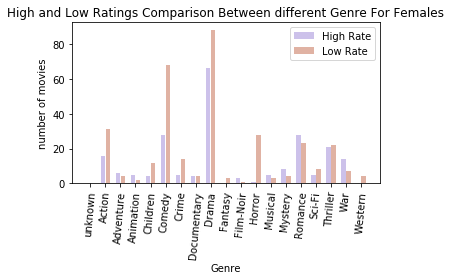

{'unknown': 0, 'Action': 16, 'Adventure': 6, 'Animation': 5, 'Children': 4, 'Comedy': 28, 'Crime': 5, 'Documentary': 4, 'Drama': 66, 'Fantasy': 0, 'Film-Noir': 3, 'Horror': 1, 'Musical': 5, 'Mystery': 8, 'Romance': 28, 'Sci-Fi': 5, 'Thriller': 21, 'War': 14, 'Western': 0}
{'unknown': 0, 'Action': 31, 'Adventure': 4, 'Animation': 2, 'Children': 12, 'Comedy': 68, 'Crime': 14, 'Documentary': 4, 'Drama': 88, 'Fantasy': 3, 'Film-Noir': 1, 'Horror': 28, 'Musical': 3, 'Mystery': 4, 'Romance': 23, 'Sci-Fi': 8, 'Thriller': 22, 'War': 7, 'Western': 4}


In [15]:
movies_rating_females = female_rating.merge(data_i, on='movie_id', how='inner')

movies_high_rating_female = movies_rating_females.loc[movies_rating_females['rating'] > 4.0]
movies_low_rating_female = movies_rating_females.loc[movies_rating_females['rating'] <= 2.0]


genre_high_counts_female = {}
genre_low_counts_female = {}

for genre in genres:
    genre_high_counts_female[genre] = movies_high_rating_female[movies_high_rating_female[genre] == 1].shape[0]
    genre_low_counts_female[genre] = movies_low_rating_female[movies_low_rating_female[genre] == 1].shape[0]

fig, ax = plt.subplots()
index = np.arange(0, 3*len(genres), 3)
ax.bar(np.arange(0, 3*len(genres), 3), [genre_high_counts_female[genre] for genre in genres], color=(0.5, 0.4, 0.8, 0.4),
       width=0.9, label='High Rate')
ax.bar(np.arange(1, 3*len(genres)+1, 3), [genre_low_counts_female[genre] for genre in genres], color=(0.8, 0.5, 0.4, 0.6),
       width=0.9, label='Low Rate')

ax.set_xlabel("Genre")
ax.set_ylabel('number of movies')
ax.set_title('High and Low Ratings Comparison Between different Genre For Females')
ax.set_xticks(index+0.5)
ax.set_xticklabels(genres, rotation=85)
ax.legend()
fig.tight_layout()
plt.show()

print(genre_high_counts_female)
print(genre_low_counts_female)


### High and Low Ratings Comparison Between different Genre For Males 

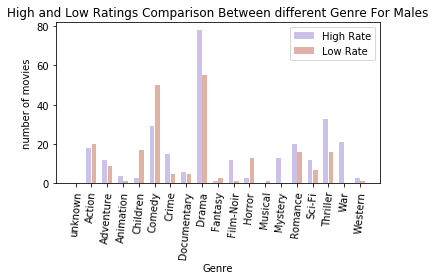

{'unknown': 0, 'Action': 18, 'Adventure': 12, 'Animation': 4, 'Children': 3, 'Comedy': 29, 'Crime': 15, 'Documentary': 6, 'Drama': 78, 'Fantasy': 1, 'Film-Noir': 12, 'Horror': 3, 'Musical': 0, 'Mystery': 13, 'Romance': 20, 'Sci-Fi': 12, 'Thriller': 33, 'War': 21, 'Western': 3}
{'unknown': 0, 'Action': 20, 'Adventure': 9, 'Animation': 1, 'Children': 17, 'Comedy': 50, 'Crime': 5, 'Documentary': 5, 'Drama': 55, 'Fantasy': 3, 'Film-Noir': 1, 'Horror': 13, 'Musical': 1, 'Mystery': 0, 'Romance': 16, 'Sci-Fi': 7, 'Thriller': 16, 'War': 0, 'Western': 1}


In [16]:
movies_rating_males = male_rating.merge(data_i, on='movie_id', how='inner')

movies_high_rating_male = movies_rating_males.loc[movies_rating_males['rating'] > 4.0]
movies_low_rating_male = movies_rating_males.loc[movies_rating_males['rating'] <= 2.0]


genre_high_counts_male = {}
genre_low_counts_male = {}

for genre in genres:
    genre_high_counts_male[genre] = movies_high_rating_male[movies_high_rating_male[genre] == 1].shape[0]
    genre_low_counts_male[genre] = movies_low_rating_male[movies_low_rating_male[genre] == 1].shape[0]

fig, ax = plt.subplots()
index = np.arange(0, 3*len(genres), 3)
ax.bar(np.arange(0, 3*len(genres), 3), [genre_high_counts_male[genre] for genre in genres], color=(0.5, 0.4, 0.8, 0.4),
       width=0.9, label='High Rate')
ax.bar(np.arange(1, 3*len(genres)+1, 3), [genre_low_counts_male[genre] for genre in genres], color=(0.8, 0.5, 0.4, 0.6),
       width=0.9, label='Low Rate')

ax.set_xlabel("Genre")
ax.set_ylabel('number of movies')
ax.set_title('High and Low Ratings Comparison Between different Genre For Males')
ax.set_xticks(index+0.5)
ax.set_xticklabels(genres, rotation=85)
ax.legend()
fig.tight_layout()
plt.show()

print(genre_high_counts_male)
print(genre_low_counts_male)


### 10 most popular movies 

In [17]:
count_ratings = data.groupby('movie_id')['rating'].count().reset_index(name="count")

populars = count_ratings.merge(data_i, on='movie_id', how="inner").sort_values(by="count", ascending=False)
print(populars.head(10)['movie_title'])

49                  Star Wars (1977)
180        Return of the Jedi (1983)
257                   Contact (1997)
99                      Fargo (1996)
293                 Liar Liar (1997)
287                    Scream (1996)
285      English Patient, The (1996)
0                   Toy Story (1995)
120    Independence Day (ID4) (1996)
299             Air Force One (1997)
Name: movie_title, dtype: object


# Part 2

## Exercise 2

### Preparing Data

In [18]:
train_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
data_train = pd.read_csv("ml-100k/u1.base", delimiter='\t', names=train_cols)
test_cols = ['user_id', 'movie_id', 'rating', 'timestamp', 'predict_rating', 'difference']
data_test = pd.read_csv("ml-100k/u1.test", delimiter='\t', names=test_cols)
average_movie_train = data_train.groupby('movie_id')['rating'].mean()
average_movie_train_int = average_movie_train.astype(int)
avg = average_movie_train_int.values.mean()
avg = avg.astype(int)

average_movie_train_df = pd.DataFrame({'rating_avg': data_train.groupby('movie_id')['rating'].mean()}).reset_index()
average_movie_train_df.sort_values(by='rating_avg', ascending=False, inplace=True)
average_movie_train_df = average_movie_train_df.reset_index(drop=True)
user_movies_train_df = pd.DataFrame({'movies_list': data_train.groupby('user_id')['movie_id'].apply(list)}).reset_index()
user_movies_test_df = pd.DataFrame({'movies_list': data_test.groupby('user_id')['movie_id'].apply(list)}).reset_index()

### User Recommendations 

In [19]:
def user_recommendations(user_movies_train_df,average_movie_train_df):
    user_recommendations_avg = {}
    user_recommendations_random = {}
    for index, row in user_movies_train_df.iterrows():
        id = row['user_id']
        movies = row['movies_list']
        rec_list_avg = []
        i = 0
        # Average
        while len(rec_list_avg) < 20:
            must_pop_avg = average_movie_train_df.iloc[i]['movie_id'].astype(int)        
            if must_pop_avg not in movies:
                rec_list_avg.append(must_pop_avg)
            i = i + 1
        user_recommendations_avg[id] = rec_list_avg
        # Random
        rec_list_random = list(average_movie_train_df.sample(n=20)['movie_id'])
        user_recommendations_random[id] = rec_list_random
    return user_recommendations_avg, user_recommendations_random

In [20]:
all_user_recommendations_avg, all_user_recommendations_random = user_recommendations(user_movies_train_df, average_movie_train_df)
print('all user recommendations avg', all_user_recommendations_avg)
print('all user recommendations random', all_user_recommendations_random)


all user recommendations avg {1: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 408, 850, 1594, 1642, 318, 483, 64, 12, 603, 114], 2: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 408, 169, 850, 1594, 1642, 318, 483, 64, 12, 50], 3: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 408, 169, 850, 1594, 1642, 318, 483, 64, 12, 50], 4: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 408, 169, 850, 1594, 1642, 318, 483, 64, 12, 50], 5: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 850, 1594, 1642, 318, 483, 64, 12, 603, 114, 1191], 6: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 850, 1594, 1642, 318, 483, 603, 114, 1191, 119, 1639], 7: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 408, 169, 850, 1594, 1642, 483, 114, 1191, 119, 1639], 8: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 408, 169, 850, 1594, 1642, 318, 483, 64, 12, 50], 9: [1189, 1653, 1599, 1500, 1467, 1201, 1122,

### MAE 

In [21]:
def avg_movie(movie_id, average_movie_train_int):
    if movie_id in average_movie_train_int:
        return average_movie_train_int[movie_id]
    else:
        return None


def calc_mae(data_test, average_movie_train_int, avg):
    for index, row in data_test.iterrows():
        predict_value = avg_movie(row['movie_id'], average_movie_train_int)
        if predict_value is None:
            predict_value = avg
        data_test.at[index, 'predict_rating'] = predict_value    
        real_value = row['rating']
        difference = pd.np.absolute(real_value - predict_value)
        data_test.at[index, 'difference'] = difference 
    numerator = data_test['difference'].sum()
    denominator = data_test.shape[0]
    mae = numerator/denominator    
    return mae

In [22]:
all_mae = calc_mae(data_test, average_movie_train_int, avg)
print('MAE: ', all_mae)

MAE:  0.94175


### Recall and Precision

In [23]:
def recall_precision(user_movies_test_df, user_recommendations_avg, user_recommendations_random):
    user_recall_avg = []
    user_recall_random = []
    user_precision_avg = []
    user_precision_random = []
    
    for index, row in user_movies_test_df.iterrows():
        id = row['user_id']
        true = row['movies_list']
        pred_avg = user_recommendations_avg[id]
        pred_random = user_recommendations_random[id]
        
        size_true = len(true)
        size_pred_avg = len(pred_avg)    
        size_pred_random = len(pred_random)
        
        common_avg = list(set(true).intersection(pred_avg))
        common_random = list(set(true).intersection(pred_random))
        
        number_common_avg = len(common_avg)
        number_common_random = len(common_random)
        
        recall_avg = number_common_avg / size_true
        user_recall_avg.append(recall_avg)
        recall_random = number_common_random / size_true
        user_recall_random.append(recall_random)
        
        precision_avg = number_common_avg / size_pred_avg
        user_precision_avg.append(precision_avg)
        precision_random = number_common_random / size_pred_random
        user_precision_random.append(precision_random)
    
    recall_for_avg = np.mean(user_recall_avg)
    recall_for_random = np.mean(user_recall_random)
    precision_for_avg = np.mean(user_precision_avg)
    precision_for_random = np.mean(user_precision_random)
    return recall_for_avg, recall_for_random, precision_for_avg,precision_for_random

In [24]:
all_recall_for_avg, all_recall_for_random, all_precision_for_avg, all_precision_for_random = recall_precision(user_movies_test_df, all_user_recommendations_avg, all_user_recommendations_random)
print('recall for avg', all_recall_for_avg)
print('recall for random', all_recall_for_random)
print('precision for avg', all_precision_for_avg)
print('precision for random', all_precision_for_random)

recall for avg 0.02233534107339741
recall for random 0.01676369077300258
precision for avg 0.04586056644880174
precision for random 0.03137254901960784


### Preparing Data - Merge

In [25]:
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
data_user = pd.read_csv('ml-100k/u.user', delimiter='|', names=user_cols)
users_ratings_train = data_train.merge(data_user, on='user_id', how='inner')
users_ratings_test = data_test.merge(data_user, on='user_id', how='inner')

### Preparing Data - Males

In [26]:
data_train_males = users_ratings_train.loc[users_ratings_train['gender'] == 'M']
data_test_males = users_ratings_test.loc[users_ratings_test['gender'] == 'M']
average_movie_train_males = data_train_males.groupby('movie_id')['rating'].mean()
average_movie_train_males_int = average_movie_train_males.astype(int)
avg_males = average_movie_train_males_int.values.mean()
avg_males = avg_males.astype(int)

average_movie_train_males_df = pd.DataFrame({'rating_avg': data_train_males.groupby('movie_id')['rating'].mean()}).reset_index()
average_movie_train_males_df.sort_values(by='rating_avg', ascending=False, inplace=True)
average_movie_train_males_df = average_movie_train_males_df.reset_index(drop=True)
user_movies_train_males_df = pd.DataFrame({'movies_list': data_train_males.groupby('user_id')['movie_id'].apply(list)}).reset_index()
user_movies_test_males_df = pd.DataFrame({'movies_list': data_test_males.groupby('user_id')['movie_id'].apply(list)}).reset_index()



### User Recommendations - Males

In [27]:
males_recommendations_avg, males_recommendations_random = user_recommendations(user_movies_train_males_df, average_movie_train_males_df)
print('males recommendations avg', males_recommendations_avg)
print('males recommendations random', males_recommendations_random)


males recommendations avg {1: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 408, 1158, 1499, 1473], 3: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 408, 169, 1158, 1499], 4: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 408, 169, 1158, 1499], 6: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 1158, 1499, 1473, 1251], 7: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 408, 169, 1158, 1499], 8: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 408, 169, 1158, 1499], 9: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 408, 169, 1158, 1499], 10: [1500, 1189, 1656, 1144, 1175, 1122, 1201, 1605, 1612, 1653, 1467, 1293, 1191, 1449, 1367, 851, 408, 169, 1158, 

### MAE - Males

In [28]:
males_mae = calc_mae(data_test_males, average_movie_train_males_int, avg_males)
print('males MAE: ', males_mae)


males MAE:  0.9192984769565504


### Recall and Precision - Males

In [29]:
males_recall_for_avg, males_recall_for_random, males_precision_for_avg, males_precision_for_random = recall_precision(user_movies_test_males_df, males_recommendations_avg, males_recommendations_random)
print('males recall for avg: ', males_recall_for_avg)
print('males recall for random: ', males_recall_for_random)
print('males precision for avg: ', males_precision_for_avg)
print('males precision for random: ', males_precision_for_random)


males recall for avg:  0.00239061447012157
males recall for random:  0.01202321443923118
males precision for avg:  0.005945121951219513
males precision for random:  0.027134146341463414


### Preparing Data - Females

In [30]:
data_train_females = users_ratings_train.loc[users_ratings_train['gender'] == 'F']
data_test_females = users_ratings_test.loc[users_ratings_test['gender'] == 'F']
average_movie_train_females = data_train_females.groupby('movie_id')['rating'].mean()
average_movie_train_females_int = average_movie_train_females.astype(int)
avg_females = average_movie_train_females_int.values.mean()
avg_females = avg_females.astype(int)

average_movie_train_females_df = pd.DataFrame({'rating_avg': data_train_females.groupby('movie_id')['rating'].mean()}).reset_index()
average_movie_train_females_df.sort_values(by='rating_avg', ascending=False, inplace=True)
average_movie_train_females_df = average_movie_train_females_df.reset_index(drop=True)
user_movies_train_females_df = pd.DataFrame({'movies_list': data_train_females.groupby('user_id')['movie_id'].apply(list)}).reset_index()
user_movies_test_females_df = pd.DataFrame({'movies_list': data_test_females.groupby('user_id')['movie_id'].apply(list)}).reset_index()



### User Recommendations - Females

In [31]:
females_recommendations_avg, females_recommendations_random = user_recommendations(user_movies_train_females_df, average_movie_train_females_df)
print('females recommendations avg: ', females_recommendations_avg)
print('females recommendations random: ', females_recommendations_random)


females recommendations avg:  {2: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 408, 318, 169, 524, 114, 915], 5: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 318, 524, 114, 915, 966, 1642], 11: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 408, 169, 524, 114, 915, 966], 12: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 408, 318, 169, 524, 114, 915], 15: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 408, 318, 169, 524, 114, 915], 18: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 408, 318, 169, 114, 915, 966], 20: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 408, 318, 169, 524, 114, 915], 23: [1594, 1150, 1301, 1189, 838, 1172, 1218, 1599, 74, 1368, 891, 1131, 1472, 1015, 318, 169, 524, 114, 915, 966], 24: [1594, 1150, 1301, 1189, 838, 1172, 12

### MAE - Females

In [32]:
females_mae = calc_mae(data_test_females, average_movie_train_females_int, avg_females)
print('females MAE: ', females_mae)


females MAE:  1.010552451893234


### Recall and Precision - Females

In [33]:
females_recall_for_avg, females_recall_for_random, females_precision_for_avg, females_precision_for_random = recall_precision(user_movies_test_females_df, females_recommendations_avg, females_recommendations_random)
print('females recall for avg: ', females_recall_for_avg)
print('females recall for random: ', females_recall_for_random)
print('females precision for avg: ', females_precision_for_avg)
print('females precision for random: ', females_precision_for_random)


females recall for avg:  0.007551077332771078
females recall for random:  0.01041225763687725
females precision for avg:  0.01908396946564886
females precision for random:  0.022900763358778626


# Part 3

## Exercise 3

### Get data

In [34]:

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_base = tc.SFrame.read_csv(path.join(data_dir, 'u1.base'), delimiter='\t',  header=False)
ratings_test = tc.SFrame.read_csv(path.join(data_dir, 'u1.test'), delimiter='\t',  header=False)

m_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
          'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
          'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = tc.SFrame.read_csv(path.join(data_dir, 'u.item'), delimiter='|',  header=False)


# Changing column names
new_rating_columns = dict(zip(ratings_base.column_names(), r_cols))
new_movies_columns = dict(zip(movies.column_names(), m_cols))
ratings_training = ratings_base.rename(new_rating_columns)
ratings_testing = ratings_test.rename(new_rating_columns)
movies = movies.rename(new_movies_columns)
ratings_training.head()

Finished parsing file /Users/sivanr/PycharmProjects/eCommerce/ml-100k/u1.base

Parsing completed. Parsed 100 lines in 0.039573 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/sivanr/PycharmProjects/eCommerce/ml-100k/u1.base

Parsing completed. Parsed 80000 lines in 0.033188 secs.

Finished parsing file /Users/sivanr/PycharmProjects/eCommerce/ml-100k/u1.test

Parsing completed. Parsed 100 lines in 0.011296 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/sivanr/PycharmProjects/eCommerce/ml-100k/u1.test

Parsing completed. Parsed 20000 lines in 0.014976 secs.

Finished parsing file /Users/sivanr/PycharmProjects/eCommerce/ml-100k/u.item

Parsing completed. Parsed 100 lines in 0.00801 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,str,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/sivanr/PycharmProjects/eCommerce/ml-100k/u.item

Parsing completed. Parsed 1682 lines in 0.009595 secs.

user_id,movie_id,rating,timestamp
1,1,5,874965758
1,2,3,876893171
1,3,4,878542960
1,4,3,876893119
1,5,3,889751712
1,7,4,875071561
1,8,1,875072484
1,9,5,878543541
1,11,2,875072262
1,13,5,875071805


### Helper function to evaluate the models by MAE

In [35]:
def evaluate_model(model, test_data):
    predictions = model.predict(test_data)
    return mean_absolute_error(test_data['rating'], predictions)


### Creating and evaluating the models

#### Ranking factorization 

In [36]:
# predict rating with ranking_factorization_recommender
start = datetime.now()
ranking_factorization_model = tc.ranking_factorization_recommender.create(ratings_training,
                                                                          'user_id', 'movie_id', 'rating')
ranking_factorization_mae = evaluate_model(ranking_factorization_model, ratings_testing)
ranking_factorization_duration = datetime.now() - start


Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.10548s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | Not Viable                               |

| 4       | 0.0651042         | 1.82169                                  |

| 5       | 0.0325521         | 1.74752                                  |

| 6       | 0.016276          | 1.95069                                  |

| 7       | 0.00813802        | 2.1006                                   |

| 8       | 0.00406901        | 2.23792                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0325521         | 1.74752                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 78us         | 2.45314           | 1.11857               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.594ms     | 2.02201           | 1.0846                | 0.0325521   |

| 2       | 139.87ms     | 2.01362           | 1.09207               | 0.0325521   |

| 3       | 228.501ms    | 1.90803           | 1.04565               | 0.0325521   |

| 4       | 285.236ms    | 1.8668            | 1.03438               | 0.0325521   |

| 5       | 357.943ms    | 1.84314           | 1.02724               | 0.0325521   |

| 10      | 642.243ms    | 1.78147           | 1.00881               | 0.0325521   |

| 25      | 1.53s        | 1.66957           | 0.968408              | 0.0325521   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.6774

Final training RMSE: 0.963053

In [37]:
print("************* ranking_factorization *****************")
print("MAE: ", ranking_factorization_mae, ", duration: ", ranking_factorization_duration)


************* ranking_factorization *****************
MAE:  0.845830838159644 , duration:  0:00:07.665743


#### Factorization 

In [38]:
# predict rating with factorization_recommender
start = datetime.now()
factorization_model = tc.factorization_recommender.create(ratings_training,
                                                          'user_id', 'movie_id', 'rating')
factorization_mae = evaluate_model(factorization_model, ratings_testing)
factorization_duration = datetime.now() - start


Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.105301s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.733696                                 |

| 4       | 0.130208          | 0.256397                                 |

| 5       | 0.0651042         | 0.661617                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.130208          | 0.256397                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 1.25116           | 1.11855               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.878ms     | 1.19337           | 1.09241               | 0.130208    |

| 2       | 162.399ms    | 0.942251          | 0.970694              | 0.130208    |

| 3       | 225.444ms    | 0.895295          | 0.946199              | 0.130208    |

| 4       | 332.616ms    | 0.875113          | 0.935473              | 0.130208    |

| 5       | 448.139ms    | 0.85825           | 0.926416              | 0.130208    |

| 10      | 791.566ms    | 0.810077          | 0.90004               | 0.130208    |

| 50      | 3.37s        | 0.685607          | 0.828007              | 0.130208    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.665594

Final training RMSE: 0.815833

In [39]:
print("************* factorization *****************")
print("MAE: ", factorization_mae, ", duration: ", factorization_duration)


************* factorization *****************
MAE:  0.7565601661911887 , duration:  0:00:07.025759


#### Item similarity

In [40]:
# predict rating with item_similarity_recommender
start = datetime.now()
item_similarity_model = tc.item_similarity_recommender.create(ratings_training,
                                                              'user_id', 'movie_id', 'rating')
item_similarity_mae = evaluate_model(item_similarity_model, ratings_testing)
item_similarity_duration = datetime.now() - start


Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.08396s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.555ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.385ms                             | 0                | 2               |

| 55.773ms                            | 100              | 1650            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.067901s

In [41]:
print("************* item_similarity *****************")
print("MAE: ", item_similarity_mae, ", duration: ", item_similarity_duration)


************* item_similarity *****************
MAE:  3.4904021554697793 , duration:  0:00:00.363404


#### Item content

In [42]:
# predict rating with item_content_recommender
start = datetime.now()
item_content_model = tc.item_content_recommender.create(item_data=movies, observation_data=ratings_training,
                                                        user_id='user_id', item_id='movie_id', target='rating')
item_content_mae = evaluate_model(item_content_model, ratings_testing)
item_content_duration = datetime.now() - start


Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Excluded Features : ['movie_id']

Column              Type  Interpretation  Transforms                         Output Type
------------------  ----  --------------  ---------------------------------  -----------
movie_title         str   short_text      3-Character NGram Counts -> TFIDF  dict       
release_date        str   categorical     None                               str        
video_release_date  str   categorical     None                               str        
IMDb_URL            str   short_text      3-Character NGram Counts -> TFIDF  dict       
unknown             int   categorical     astype(str)  

Starting brute force nearest neighbors model training.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 1682    | 0.059453    | 8.404ms      |

| Done         |         | 100         | 298.26ms     |

+--------------+---------+-------------+--------------+

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 80000 observations with 943 users and 1682 items.

Data prepared in: 0.168434s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.015407s

In [43]:
print("************* item_content *****************")
print("MAE: ", item_content_mae, ", duration: ", item_content_duration)


************* item_content *****************
MAE:  3.3744986432838386 , duration:  0:00:05.166384


### Compare models 

In [44]:
# compare models
tc.recommender.util.compare_models(ratings_testing,
                                   [ranking_factorization_model,
                                    factorization_model,
                                    item_similarity_model,
                                    item_content_model],
                                   model_names=["ranking_factorization",
                                                "factorization",
                                                "item_similarity",
                                                "item_content"])


PROGRESS: Evaluate model ranking_factorization

Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.35729847494553374 | 0.010098032022047135 |
|   2    | 0.33224400871459703 | 0.017364570956093114 |
|   3    |  0.3159041394335515 | 0.02510939405896662  |
|   4    |  0.2973856209150328 | 0.030289199249996002 |
|   5    |  0.2897603485838782 | 0.037044165251243294 |
|   6    | 0.28213507625272344 | 0.04262608407782564  |
|   7    |  0.2754435107376285 | 0.047820050135464996 |
|   8    |  0.270152505446623  | 0.05305437420871627  |
|   9    | 0.26797385620915026 | 0.058501646827160594 |
|   10   |  0.2631808278867104 | 0.062350845030220536 |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0310641105156237

Per User RMSE (best)
+---------+---------------------+------

[{'precision_recall_by_user': Columns:
  	user_id	int
  	cutoff	int
  	precision	float
  	recall	float
  	count	int
  
  Rows: 8262
  
  Data:
  +---------+--------+--------------------+-----------------------+-------+
  | user_id | cutoff |     precision      |         recall        | count |
  +---------+--------+--------------------+-----------------------+-------+
  |    1    |   1    |        1.0         | 0.0072992700729927005 |  137  |
  |    1    |   2    |        1.0         |  0.014598540145985401 |  137  |
  |    1    |   3    |        1.0         |  0.021897810218978103 |  137  |
  |    1    |   4    |        0.75        |  0.021897810218978103 |  137  |
  |    1    |   5    |        0.6         |  0.021897810218978103 |  137  |
  |    1    |   6    | 0.6666666666666666 |  0.029197080291970802 |  137  |
  |    1    |   7    | 0.5714285714285714 |  0.029197080291970802 |  137  |
  |    1    |   8    |        0.5         |  0.029197080291970802 |  137  |
  |    1    |   9    

## Exercise 4 

### Getting the data

In [45]:
RATING_DATA_FILE_TRAIN = 'u1.base'
RATING_DATA_FILE_TEST = 'u1.test'

# train set

ratings_training = pd.read_csv(path.join(data_dir, RATING_DATA_FILE_TRAIN),
                               sep='\t',
                               engine='python',
                               encoding='latin-1',
                               names=['userid', 'movieid', 'rating', 'timestamp'])

max_user_id_train = ratings_training['userid'].drop_duplicates().max()
max_movie_id_train = ratings_training['movieid'].drop_duplicates().max()
ratings_training['user_emb_id'] = ratings_training['userid'] - 1
ratings_training['movie_emb_id'] = ratings_training['movieid'] - 1
ratings_training['rating_norm'] = ratings_training['rating'] * 0.2
print(str(len(ratings_training))+' ratings loaded for training')


Users_train = ratings_training['user_emb_id'].values
Movies_train = ratings_training['movie_emb_id'].values
Ratings_train = ratings_training['rating'].values

# test set

ratings_testing = pd.read_csv(path.join(data_dir, RATING_DATA_FILE_TEST),
                              sep='\t',
                              engine='python',
                              encoding='latin-1',
                              names=['userid', 'movieid', 'rating', 'timestamp'])

max_user_id_test = ratings_testing['userid'].drop_duplicates().max()
max_movie_id_test = ratings_testing['movieid'].drop_duplicates().max()
ratings_testing['user_emb_id'] = ratings_testing['userid'] - 1
ratings_testing['movie_emb_id'] = ratings_testing['movieid'] - 1
ratings_testing['rating_norm'] = ratings_testing['rating'] * 0.2
print(str(len(ratings_testing))+' ratings loaded for testing')


Users_test = ratings_testing['user_emb_id'].values
Movies_test = ratings_testing['movie_emb_id'].values
Ratings_test = ratings_testing['rating'].values


80000 ratings loaded for training
20000 ratings loaded for testing


### Build the models 

#### Helper functions 

In [46]:
def get_hidden_layer(layer, hidden_dim, activation, number_of_hidden_layers=1):
    while number_of_hidden_layers != 0:
        layer = Dense(hidden_dim, activation=activation)(layer)
        number_of_hidden_layers -= 1
    return layer


def get_ncf_model(num_users, num_items, latent_dim, hidden_dim, dropout, activation='relu', number_of_hidden_layers=1):
    # Input layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # embedding layers
    embedding_user = Embedding(input_dim=num_users, output_dim=latent_dim, name='user_embedding', input_length=1)
    embedding_item = Embedding(input_dim=num_items, output_dim=latent_dim, name='item_embedding', input_length=1)

    # flatten
    user_latent = Flatten()(embedding_user(user_input))
    item_latent = Flatten()(embedding_item(item_input))

    # Element-wise product of user and item embeddings
    concatenate = Concatenate()([user_latent, item_latent])
    hidden_layer = get_hidden_layer(concatenate, hidden_dim, activation, number_of_hidden_layers)
    drop = Dropout(dropout)(hidden_layer)
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name='prediction')(drop)

    model = Model(input=[user_input, item_input], output=prediction)
    print("ncf model")
    model.summary()

    return model


#### Option 1

In [47]:
K_LATENT = 20
HIDDEN_DIM = 20
DROPOUT = 0.5

option1 = {
    'activation': 'relu',
    'loss': 'mse',
    'optimizer': Adamax(lr=0.001),
    'number_of_layers': 1
}

start = datetime.now()
option1_model = get_ncf_model(max_user_id_train,max_movie_id_train, K_LATENT, 
                          HIDDEN_DIM, DROPOUT, option1['activation'], option1['number_of_layers'])
option1_model.compile(loss=option1['loss'], optimizer=option1['optimizer'], metrics=['mae'])
print(option1_model.summary())



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
ncf model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18860       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedd

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [48]:
option1_history = option1_model.fit([Users_train, Movies_train], Ratings_train, epochs=50,
                                    verbose=1, batch_size=32,
                                    validation_data=([Users_test, Movies_test], Ratings_test))

option1_duration = datetime.now() - start


Instructions for updating:
Use tf.cast instead.
Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 3s 32us/step - loss: 2.8312 - mean_absolute_error: 1.3217 - val_loss: 1.0772 - val_mean_absolute_error: 0.8516
Epoch 2/50
80000/80000 [==============================] - 2s 29us/step - loss: 1.3543 - mean_absolute_error: 0.9368 - val_loss: 0.9785 - val_mean_absolute_error: 0.8009
Epoch 3/50
80000/80000 [==============================] - 2s 29us/step - loss: 1.1616 - mean_absolute_error: 0.8659 - val_loss: 0.9425 - val_mean_absolute_error: 0.7802
Epoch 4/50
80000/80000 [==============================] - 2s 30us/step - loss: 1.0480 - mean_absolute_error: 0.8207 - val_loss: 0.9360 - val_mean_absolute_error: 0.7775
Epoch 5/50
80000/80000 [==============================] - 2s 30us/step - loss: 0.9855 - mean_absolute_error: 0.7952 - val_loss: 0.9304 - val_mean_absolute_error: 0.7743
Epoch 6/50
80000/80000 [==============================] -

80000/80000 [==============================] - 2s 29us/step - loss: 0.8424 - mean_absolute_error: 0.7273 - val_loss: 0.8931 - val_mean_absolute_error: 0.7494
Epoch 48/50
80000/80000 [==============================] - 2s 29us/step - loss: 0.8412 - mean_absolute_error: 0.7260 - val_loss: 0.8929 - val_mean_absolute_error: 0.7470
Epoch 49/50
80000/80000 [==============================] - 2s 30us/step - loss: 0.8446 - mean_absolute_error: 0.7279 - val_loss: 0.8922 - val_mean_absolute_error: 0.7476
Epoch 50/50
80000/80000 [==============================] - 2s 29us/step - loss: 0.8390 - mean_absolute_error: 0.7250 - val_loss: 0.8936 - val_mean_absolute_error: 0.7506


MAE: 


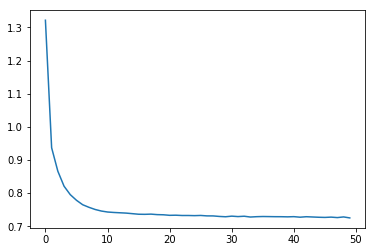

duration:  0:01:59.243331


In [49]:
# plot metrics
print('MAE: ')
plt.plot(option1_history.history['mean_absolute_error'])
plt.show()

print('duration: ', option1_duration)

#### Option 2

In [50]:
option2 = {
    'activation': 'softmax',
    'loss': 'mse',
    'optimizer': SGD(),
    'number_of_layers': 2
}

start = datetime.now()
option2_model = get_ncf_model(max_user_id_train,max_movie_id_train, K_LATENT,
                              HIDDEN_DIM, DROPOUT, option2['activation'], option2['number_of_layers'])
option2_model.compile(loss=option2['loss'], optimizer=option2['optimizer'], metrics=['mae'])
print(option2_model.summary())

option2_history = option2_model.fit([Users_train, Movies_train], Ratings_train, epochs=50,
                                    verbose=1, batch_size=32,
                                    validation_data=([Users_test, Movies_test], Ratings_test))

option2_duration = datetime.now() - start


ncf model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18860       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
__________________________________________________________________________________________________


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 3s 31us/step - loss: 7.6437 - mean_absolute_error: 2.5283 - val_loss: 7.7617 - val_mean_absolute_error: 2.5359
Epoch 2/50
80000/80000 [==============================] - 2s 28us/step - loss: 7.6437 - mean_absolute_error: 2.5283 - val_loss: 7.7617 - val_mean_absolute_error: 2.5359
Epoch 3/50
80000/80000 [==============================] - 2s 28us/step - loss: 7.6437 - mean_absolute_error: 2.5283 - val_loss: 7.7617 - val_mean_absolute_error: 2.5359
Epoch 4/50
80000/80000 [==============================] - 2s 28us/step - loss: 7.6437 - mean_absolute_error: 2.5283 - val_loss: 7.7617 - val_mean_absolute_error: 2.5359
Epoch 5/50
80000/80000 [==============================] - 2s 28us/step - loss: 7.6437 - mean_absolute_error: 2.5283 - val_loss: 7.7617 - val_mean_absolute_error: 2.5359
Epoch 6/50
80000/80000 [==============================] - 2s 28us/step - loss: 7.6437 - mean_absolute_err

Epoch 49/50
80000/80000 [==============================] - 2s 28us/step - loss: 7.6437 - mean_absolute_error: 2.5283 - val_loss: 7.7617 - val_mean_absolute_error: 2.5359
Epoch 50/50
80000/80000 [==============================] - 2s 28us/step - loss: 7.6437 - mean_absolute_error: 2.5283 - val_loss: 7.7617 - val_mean_absolute_error: 2.5359


MAE: 


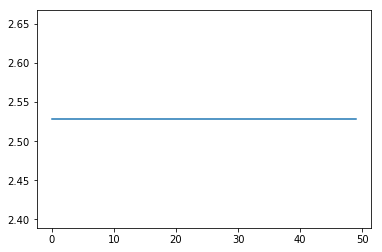

duration:  0:01:52.994783


In [51]:
print('MAE: ')

# plot metrics
plt.plot(option2_history.history['mean_absolute_error'])
plt.show()

print('duration: ', option2_duration)

#### Option 3 

In [52]:

option3 = {
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adamax(),
    'number_of_layers': 2
}

start = datetime.now()

option3_model = get_ncf_model(max_user_id_train,max_movie_id_train, K_LATENT,
                              HIDDEN_DIM, DROPOUT, option3['activation'], option3['number_of_layers'])
option3_model.compile(loss=option3['loss'], optimizer=option3['optimizer'], metrics=['mae'])
print(option3_model.summary())

option3_history = option3_model.fit([Users_train, Movies_train], Ratings_train, epochs=50,
                                    verbose=1, batch_size=32,
                                    validation_data=([Users_test, Movies_test], Ratings_test))

option3_duration = datetime.now() - start


ncf model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18860       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
__________________________________________________________________________________________________


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 3s 42us/step - loss: -28.0342 - mean_absolute_error: 2.1213 - val_loss: -40.4283 - val_mean_absolute_error: 1.4396
Epoch 2/50
80000/80000 [==============================] - 3s 37us/step - loss: -39.0389 - mean_absolute_error: 1.3748 - val_loss: -40.4283 - val_mean_absolute_error: 1.0318
Epoch 3/50
80000/80000 [==============================] - 3s 36us/step - loss: -39.5868 - mean_absolute_error: 1.3964 - val_loss: -40.4283 - val_mean_absolute_error: 0.9903
Epoch 4/50
80000/80000 [==============================] - 3s 37us/step - loss: -40.0324 - mean_absolute_error: 1.7657 - val_loss: -40.4283 - val_mean_absolute_error: 1.3254
Epoch 5/50
80000/80000 [==============================] - 3s 37us/step - loss: -40.1348 - mean_absolute_error: 1.9846 - val_loss: -40.4283 - val_mean_absolute_error: 1.4741
Epoch 6/50
80000/80000 [==============================] - 3s 37us/step - loss: -40.14

Epoch 48/50
80000/80000 [==============================] - 3s 36us/step - loss: -40.3079 - mean_absolute_error: 2.5462 - val_loss: -40.4283 - val_mean_absolute_error: 2.1632
Epoch 49/50
80000/80000 [==============================] - 4s 45us/step - loss: -40.3079 - mean_absolute_error: 2.5508 - val_loss: -40.4283 - val_mean_absolute_error: 2.1632
Epoch 50/50
80000/80000 [==============================] - 3s 39us/step - loss: -40.3079 - mean_absolute_error: 2.5534 - val_loss: -40.4283 - val_mean_absolute_error: 2.1632


MAE: 


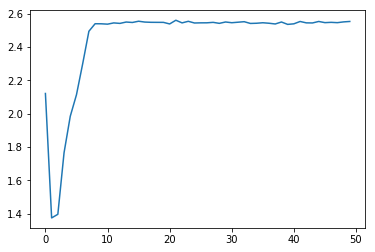

duration:  0:02:27.614140


In [53]:
print('MAE: ')
# plot metrics
plt.plot(option3_history.history['mean_absolute_error'])
plt.show()
print('duration: ', option3_duration)

### Compare models 

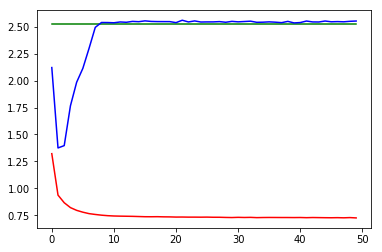

In [54]:
plt.plot(option1_history.history['mean_absolute_error'],'r',
         option2_history.history['mean_absolute_error'], 'g',
         option3_history.history['mean_absolute_error'], 'b')
plt.show()


## Execrise 5 

### Getting the data

In [55]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
i_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
          'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
          'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

train_data = pd.read_csv(path.join(data_dir, 'u1.base'), delimiter='\t', names=r_cols)
test_data = pd.read_csv(path.join(data_dir, 'u1.test'), delimiter='\t', names=r_cols)
data_i = pd.read_csv(path.join(data_dir, 'u.item'), delimiter='|', names=i_cols,
                     encoding='latin-1')
data_u = pd.read_csv(path.join(data_dir, 'u.user'), delimiter='|', names=u_cols)


### Marge items, users and rating and remove irrelevant columns

In [56]:

movies_rating_train = data_i.merge(train_data, on='movie_id', how='inner')
movies_rating_test = data_i.merge(test_data, on='movie_id', how='inner')

users_ratings_train = train_data.merge(data_u, on='user_id', how='inner')
users_ratings_test = test_data.merge(data_u, on='user_id', how='inner')

movies_users_ratings_train = movies_rating_train.merge(users_ratings_train, on=['user_id', 'movie_id'], how='inner',
                                                       suffixes=('', '_y'))
movies_users_ratings_test = movies_rating_test.merge(users_ratings_test, on=['user_id', 'movie_id'], how='inner',
                                                     suffixes=('', '_y'))

columns_to_drop = ['movie_id', 'movie_title', 'user_id', 'rating_y', 'timestamp', 'timestamp_y', 'release_date',
                   'video_release_date', 'IMDb_URL', 'zip_code']
movies_users_ratings_train.drop(columns_to_drop, inplace=True, axis=1)
movies_users_ratings_test.drop(columns_to_drop, inplace=True, axis=1)

print("train set shape: ", movies_users_ratings_train.shape)
print("test set shape: ", movies_users_ratings_test.shape)


train set shape:  (80000, 23)
test set shape:  (20000, 23)


### Get dummies data from categorical features

In [57]:
cat_vars = ['gender', 'occupation']

for var in cat_vars:
    cat_list = pd.get_dummies(movies_users_ratings_train[var], prefix=var)
    movies_users_ratings_train = movies_users_ratings_train.join(cat_list)

    cat_list = pd.get_dummies(movies_users_ratings_test[var], prefix=var)
    movies_users_ratings_test = movies_users_ratings_test.join(cat_list)

print("train set shape: ", movies_users_ratings_train.shape)
print("test set shape: ", movies_users_ratings_test.shape)


train set shape:  (80000, 46)
test set shape:  (20000, 46)


### Digitize 'age' feature with 5 bins

In [58]:
movies_users_ratings_train['age'] = np.digitize(movies_users_ratings_train['age'], bins=[10, 20, 35, 50])
movies_users_ratings_test['age'] = np.digitize(movies_users_ratings_test['age'], bins=[10, 20, 35, 50])
movies_users_ratings_train.head()


,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create train set and test set for the algorithm

In [59]:
columns = movies_users_ratings_train.columns.values.tolist()
to_keep = [i for i in columns if i not in cat_vars]

movies_users_ratings_train = movies_users_ratings_train[to_keep]
movies_users_ratings_test = movies_users_ratings_test[to_keep]


X_train = movies_users_ratings_train.loc[:, movies_users_ratings_train.columns != 'rating']
X_test = movies_users_ratings_test.loc[:, movies_users_ratings_test.columns != 'rating']
y_train = movies_users_ratings_train.loc[:, movies_users_ratings_train.columns == 'rating']
y_test = movies_users_ratings_test.loc[:, movies_users_ratings_test.columns == 'rating']

print("train set shape: ", X_train.shape)
print("test set shape: ", X_test.shape)


train set shape:  (80000, 43)
test set shape:  (20000, 43)


### Predict rate with Logistic Regression and evaluate

In [60]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
logreg_mae = mean_absolute_error(y_test, y_pred)
print('MAE of logistic regression classifier on test set: {:.2f}'.format(logreg_mae))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


MAE of logistic regression classifier on test set: 0.89


### Choose 2 features ('gender and 'age') and evaluate

In [61]:
to_keep = ['age', 'gender_M', 'gender_F']
X_train = X_train.filter(to_keep)
X_test = X_test.filter(to_keep)

# logreg = RandomForestClassifier(n_estimators=20, max_depth=10, min_samples_split=3)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('MAE of logistic regression classifier on test set: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


MAE of logistic regression classifier on test set: 0.91


For each two features we evaluated the model to determine which two features give the lowest MAE with the loop below:

In [62]:
for i in range(X_train.shape[1]):
    for j in range(X_train.shape[1]):
        if i != j:
            temp_train = X_train.iloc[:, [i, j]]
            temp_test = X_test.iloc[:, [i, j]]
            logreg = LogisticRegression()
            logreg.fit(temp_train, y_train)

            y_pred = logreg.predict(temp_test)
            print("features: ", temp_train.columns.values.tolist(), ": ")
            print('MAE of logistic regression classifier on test set: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


features:  ['age', 'gender_M'] : 
MAE of logistic regression classifier on test set: 0.91
features:  ['age', 'gender_F'] : 
MAE of logistic regression classifier on test set: 0.91


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

features:  ['gender_M', 'age'] : 
MAE of logistic regression classifier on test set: 0.91
features:  ['gender_M', 'gender_F'] : 
MAE of logistic regression classifier on test set: 0.91


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

features:  ['gender_F', 'age'] : 
MAE of logistic regression classifier on test set: 0.91
features:  ['gender_F', 'gender_M'] : 
MAE of logistic regression classifier on test set: 0.91


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


We found out that the differences between the models are very small.

# Compare Performances

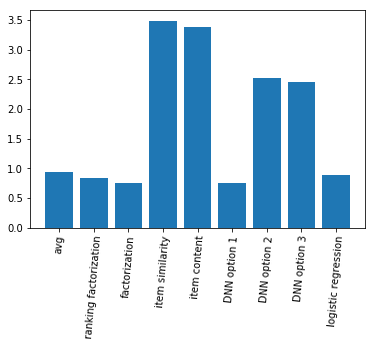

{'avg': 0.94175, 'ranking factorization': 0.845830838159644, 'factorization': 0.7565601661911887, 'item similarity': 3.4904021554697793, 'item content': 3.3744986432838386, 'DNN option 1': 0.7558303031892777, 'DNN option 2': 2.52835, 'DNN option 3': 2.4499657713437077, 'logistic regression': 0.8923}


In [63]:
mae_dict = {
    'avg': all_mae,
    'ranking factorization': ranking_factorization_mae,
    'factorization': factorization_mae,
    'item similarity': item_similarity_mae,
    'item content': item_content_mae,
    'DNN option 1': np.mean(option1_history.history['mean_absolute_error']),
    'DNN option 2': np.mean(option2_history.history['mean_absolute_error']),
    'DNN option 3': np.mean(option3_history.history['mean_absolute_error']),
    'logistic regression': logreg_mae
}
keys = list(mae_dict.keys())
plt.bar(range(len(mae_dict)), [mae_dict[key] for key in keys], align='center')
plt.xticks(range(len(mae_dict)), keys, rotation=85)

plt.show()

print(mae_dict)

As we can see, **option 1** of the **Deep neural network models** has the lowest MAE - 0.755 but is very slow training. 
The second model with the lowest MAE is **factorization** with MAE of 0.756.